In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import muon as mu
from muon import prot as pt
import os
import h5py
from mudata import MuData
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.sparse import csr_array
import anndata as ad

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/si

In [2]:
from sklearn.mixture import GaussianMixture  # different in updated sklearn (prev GMM)
from sklearn.metrics import confusion_matrix
from matplotlib.colors import rgb2hex
import milopy  # had to revert markupsafe (2.0.1) for updated version issue
import milopy.core as milo
import itertools
from distinctipy import distinctipy

In [3]:
def remove_recompute(adata):
    del adata.obsm['X_umap'], adata.obsm['X_pca'], adata.obsp, adata.uns
    sc.tl.pca(adata, svd_solver='auto')
    sc.pp.neighbors(adata)  # using with default parameters
    sc.tl.umap(adata)
    # sc.tl.diffmap(adata)
    return adata

def encode_replicates(adata, rep_dict):
    rep = [None] * adata.shape[0]
    for z in np.arange(adata.shape[0]):
        if np.sum(adata.obsm['hash_onoff'][z]) > 0:
            z_arg = np.argmax(adata.obsm['hash_onoff'][z])
            rep[z] = 'R{}'.format(z_arg+1)
        else:
            rep[z] = 'R0'
    return rep

def build_samplerep(adata, sample_slot, replicate_slot):
    sample_rep = [None] * adata.shape[0]
    for r in np.arange(adata.shape[0]):
        sample_rep[r] = str(adata.obs[sample_slot][r]) + ' ' + str(adata.obs[replicate_slot][r])
    return sample_rep


def group_nhoods(adata, min_connect, max_difflfc):
    adj_nhood = np.zeros((adata.obsm['nhoods'].shape[1], adata.obsm['nhoods'].shape[1]))

    # only considering single cells belonging to more than one
    overlap_ind = np.where(np.sum(adata.obsm['nhoods'], axis=1) > 1)[0]
    for g in overlap_ind:
        nhood_ind = np.where(adata.obsm['nhoods'][g, :].todense() == 1)[1]
        ij = list(itertools.permutations(nhood_ind, 2))
        for q in ij:
            adj_nhood[q] = adj_nhood[q] + 1

    # still need to filter adj matrix entries to zero by connections (< 3) and LFC match (diff > 0.25?)
    nonzero_ind = np.where(adj_nhood > 0)
    logFC = adata.uns['nhood_adata'].obs['logFC']
    for f in np.arange(len(nonzero_ind[0])):
        if adj_nhood[nonzero_ind[0][f], nonzero_ind[1][f]] < min_connect or abs(logFC[nonzero_ind[0][f]] - logFC[nonzero_ind[1][f]]) > max_difflfc:
            adj_nhood[nonzero_ind[0][f], nonzero_ind[1][f]] = 0

    return adj_nhood


def plot_nhood_clusters(adata, cluster_labels, title, alpha=0.1, min_size=10, plot_edges=False):
    nhood_adata = adata.uns["nhood_adata"].copy()

    nhood_adata.obs["graph_color"] = cluster_labels
    nhood_adata.obs["graph_color"] = nhood_adata.obs["graph_color"].astype('category')

    clust_col = distinctipy.get_colors(len(np.unique(nhood_adata.obs["graph_color"])))
    clust_pal = {np.unique(nhood_adata.obs["graph_color"])[i]: clust_col[i] for i in range(len(clust_col))}

    nhood_adata.obs.loc[nhood_adata.obs["SpatialFDR"] > alpha, "graph_color"] = np.nan

    # plotting order
    ordered = nhood_adata.obs.sort_values('SpatialFDR', na_position='last').index[::-1]
    nhood_adata = nhood_adata[ordered]

    sc.pl.embedding(nhood_adata, "X_milo_graph",
                    color="graph_color", palette=clust_pal,
                    size=adata.uns["nhood_adata"].obs["Nhood_size"] * min_size,
                    edges=plot_edges, neighbors_key="nhood",
                    frameon=False,
                    title=title
                    )

    return nhood_adata.obs["graph_color"], clust_pal


def plot_durable_clusters(adata, cluster_labels, title, alpha=0.1, beta=0.5, min_size=10, plot_edges=False):
    nhood_adata = adata.uns["nhood_adata"].copy()

    nhood_adata.obs["graph_color"] = cluster_labels
    nhood_adata.obs["graph_color"] = nhood_adata.obs["graph_color"].astype('category')

    clust_col = distinctipy.get_colors(len(np.unique(nhood_adata.obs["graph_color"])))
    clust_pal = {np.unique(nhood_adata.obs["graph_color"])[i]: clust_col[i] for i in range(len(clust_col))}

    nhood_adata.obs.loc[nhood_adata.obs["SpatialFDR"] < alpha, "graph_color"] = np.nan
    nhood_adata.obs.loc[nhood_adata.obs["logFC"] > beta, "graph_color"] = np.nan
    nhood_adata.obs.loc[nhood_adata.obs["logFC"] < -beta, "graph_color"] = np.nan

    sc.pl.embedding(nhood_adata, "X_milo_graph",
                    color="graph_color", palette=clust_pal,
                    size=adata.uns["nhood_adata"].obs["Nhood_size"] * min_size,
                    edges=plot_edges, neighbors_key="nhood",
                    frameon=False,
                    title=title
                    )

    return nhood_adata.obs["graph_color"], clust_pal


def get_sc_louvain(adata, cluster_slot='louvain'):
    louvain_onehot = np.zeros((adata.uns['nhood_adata'].obs[cluster_slot].shape[0], (np.unique(adata.uns['nhood_adata'].obs[cluster_slot])[-2] + 1).astype('int')))
    for c in adata.uns['nhood_adata'].obs[cluster_slot].index:
        if adata.uns['nhood_adata'].obs[cluster_slot][c] < float('inf'):
            louvain_onehot[int(c), adata.uns['nhood_adata'].obs[cluster_slot][c].astype('int')] = 1

    # get single-cell louvain neighborhood cluster labels
    sc_onehot = adata.obsm['nhoods']*louvain_onehot
    sc_louvain = np.zeros(sc_onehot.shape[0])
    for t in np.arange(sc_onehot.shape[0]):
        if np.sum(sc_onehot[t, :]) == 0:
            sc_louvain[t] = -1
        else:
            sc_louvain[t] = np.argmax(sc_onehot[t, :])

    return sc_louvain.astype('int')

In [4]:
rna_sing = sc.read('/Users/anasuyadighe/Downloads/cpi-cd40-main/Round4_celltypes_collapsed.h5ad')

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [5]:
d8_d12 = []
trt_d8 = np.where(rna_sing.obs['sample'] == 'P2-T1-d8')[0]
trt_d12 = np.where(rna_sing.obs['sample'] == 'P4-T2-d12')[0]
adata = rna_sing[np.concatenate((trt_d8, trt_d12)), :]
d8_d12.append(adata.copy())

In [6]:
concat_data = ad.concat(d8_d12, join='outer')
concat_data

AnnData object with n_obs × n_vars = 8425 × 19059
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'hashing', 'leiden', 'hashtag', 'CD45', 'leiden_0.6', 'leiden_new'
    obsm: 'X_pca', 'X_umap', 'hash_onoff'

In [8]:
concat_data = remove_recompute(concat_data)

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


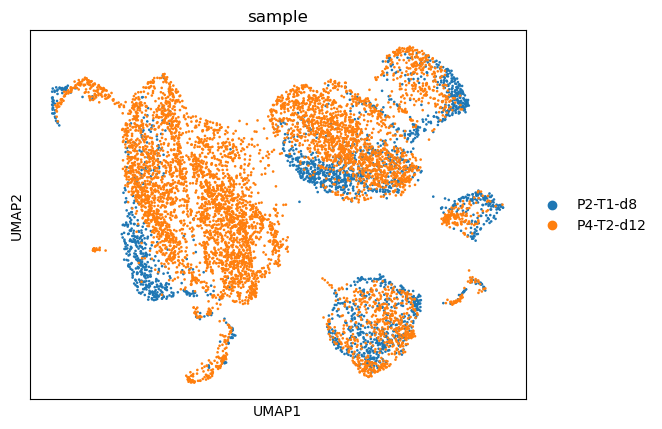

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [9]:
sc.pl.umap(concat_data, color = 'sample')
sc.pl.umap(concat_data, color = 'leiden_new', legend_loc = 'on data')

In [10]:
mac = concat_data[concat_data.obs['leiden_new'].str.contains('Macrophage')]
mac

View of AnnData object with n_obs × n_vars = 2062 × 19059
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'hashing', 'leiden', 'hashtag', 'CD45', 'leiden_0.6', 'leiden_new'
    uns: 'pca', 'neighbors', 'umap', 'sample_colors', 'leiden_new_colors'
    obsm: 'hash_onoff', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [11]:
sc.pl.umap(mac, color = 'sample')

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [12]:
mac.obs['sample'].value_counts()

sample
P4-T2-d12    1415
P2-T1-d8      647
Name: count, dtype: int64

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


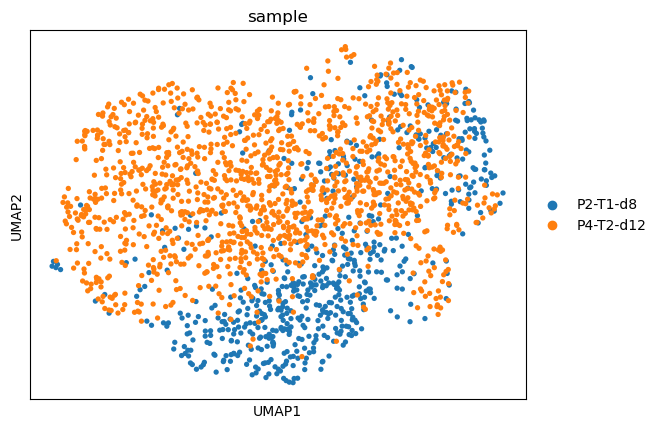

In [13]:
del mac.uns, mac.obsm, mac.varm, mac.obsp
sc.tl.pca(mac, svd_solver='arpack')
sc.pp.neighbors(mac, n_neighbors=10, n_pcs=40)  # using with default parameters
sc.tl.umap(mac)
sc.pl.umap(mac, color='sample')

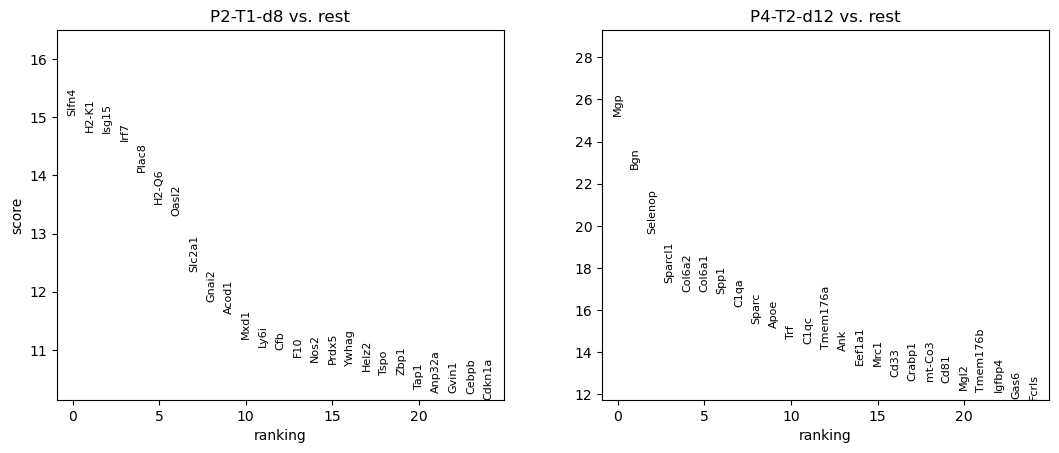

In [14]:
sc.tl.rank_genes_groups(mac, groupby='sample', key_added='mac_DE_results')
sc.pl.rank_genes_groups(mac, n_genes=25, sharey=False, key='mac_DE_results')

In [15]:
def write_deres(excel_path, adata, group, de_key):
    # writing results to excel file
    res_cat = ['names', 'scores', 'logfoldchanges', 'pvals', 'pvals_adj']

    with pd.ExcelWriter(excel_path, engine='xlsxwriter') as writer:
        for g in np.unique(mac.obs[group]):
            d = {res_cat[0]: adata.uns[de_key][res_cat[0]][str(g)].tolist(),
                 res_cat[1]: adata.uns[de_key][res_cat[1]][str(g)].tolist(),
                 res_cat[2]: adata.uns[de_key][res_cat[2]][str(g)].tolist(),
                 res_cat[3]: adata.uns[de_key][res_cat[3]][str(g)].tolist(),
                 res_cat[4]: adata.uns[de_key][res_cat[4]][str(g)].tolist()
                 }
            df = pd.DataFrame(data=d)
            df.to_excel(writer, sheet_name=str(g))

In [17]:
file_dir = '/Users/anasuyadighe/Downloads/'
write_deres(file_dir + 'GAP_flex_treated_d8_vs_d12_macrophage_DEGs.xlsx', mac, 'sample', 'mac_DE_results')

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


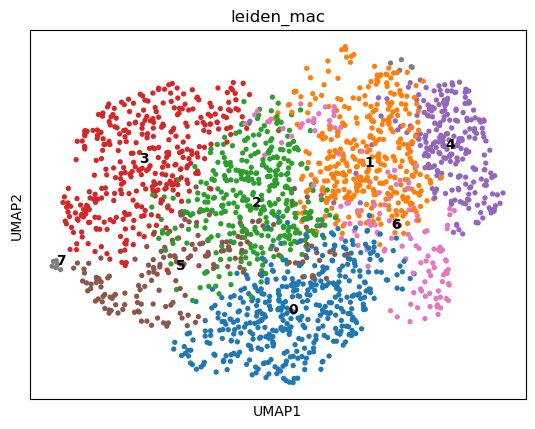

In [19]:
sc.tl.leiden(mac, resolution = 0.6, key_added = 'leiden_mac')
sc.pl.umap(mac, color = 'leiden_mac' , legend_loc = 'on data')

In [68]:
tmp = pd.crosstab(mac.obs['leiden_mac'],mac.obs['sample'], normalize='columns')
tmp.plot.bar(stacked=True).legend(bbox_to_anchor=(1.4, 1),loc='upper right')

TypeError: unstack() takes from 2 to 3 positional arguments but 4 were given

In [79]:
mac.obs['leiden_mac']


AAACGGGCATGGCCGA-1-P2-T1-d8     0
AAACTGGGTTAATCCA-1-P2-T1-d8     0
AAACTGTCATCGAACA-1-P2-T1-d8     0
AAAGATGCAATCTCTA-1-P2-T1-d8     0
AAAGATGCACCATCCA-1-P2-T1-d8     0
                               ..
TTTCATGCAGGCTTAA-1-P4-T2-d12    2
TTTCCTGGTCAGGGCA-1-P4-T2-d12    1
TTTGCTCTCTATTGAC-1-P4-T2-d12    2
TTTGGCGGTGGTTATC-1-P4-T2-d12    2
TTTGTGAGTTGGCGAG-1-P4-T2-d12    3
Name: leiden_mac, Length: 2062, dtype: object

In [73]:
mac.obs['sample']

AAACGGGCATGGCCGA-1-P2-T1-d8      P2-T1-d8
AAACTGGGTTAATCCA-1-P2-T1-d8      P2-T1-d8
AAACTGTCATCGAACA-1-P2-T1-d8      P2-T1-d8
AAAGATGCAATCTCTA-1-P2-T1-d8      P2-T1-d8
AAAGATGCACCATCCA-1-P2-T1-d8      P2-T1-d8
                                  ...    
TTTCATGCAGGCTTAA-1-P4-T2-d12    P4-T2-d12
TTTCCTGGTCAGGGCA-1-P4-T2-d12    P4-T2-d12
TTTGCTCTCTATTGAC-1-P4-T2-d12    P4-T2-d12
TTTGGCGGTGGTTATC-1-P4-T2-d12    P4-T2-d12
TTTGTGAGTTGGCGAG-1-P4-T2-d12    P4-T2-d12
Name: sample, Length: 2062, dtype: category
Categories (2, object): ['P2-T1-d8', 'P4-T2-d12']

In [80]:
# Assuming 'mac' is your DataFrame containing 'leiden_mac' and 'sample' columns
mac.obs['leiden_mac'] = mac.obs['leiden_mac'].astype(str)
mac.obs['sample'] = mac.obs['sample'].astype(str)

tmp = pd.crosstab(mac.obs['leiden_mac'], mac.obs['sample'], normalize='index')

# Plotting the stacked bar plot
tmp.plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(1.4, 1), loc='upper right')
plt.show()


TypeError: unstack() takes from 2 to 3 positional arguments but 4 were given

In [81]:
grouped = mac.obs.groupby(['leiden_mac', 'sample']).size()

In [92]:
tmp = pd.crosstab(leiden_mac_df, leiden_sample_df, normalize='index')

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_53203/4281149414.py", line 1, in <module>
    tmp = pd.crosstab(leiden_mac_df, leiden_sample_df, normalize='index')
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/pandas/core/reshape/pivot.py", line 700, in crosstab
  File "/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/pandas/core/frame.py", line 736, in __init__
    data = np.asarray(data)
  File "/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/pandas/core/internals/construction.py", line 503, in dict_to_mgr
    Convert a single sequence of arrays to multiple arrays.
           ^^^^^^^^^^^^^^^^^^^^^^

In [94]:
mac.obs.groupby('leiden_mac')["sample"].value_counts()

leiden_mac  sample   
0           P2-T1-d8     379
            P4-T2-d12     51
1           P4-T2-d12    296
            P2-T1-d8      70
2           P4-T2-d12    338
            P2-T1-d8      26
3           P4-T2-d12    344
            P2-T1-d8       8
4           P4-T2-d12    131
            P2-T1-d8     106
5           P4-T2-d12    138
            P2-T1-d8      31
6           P4-T2-d12    115
            P2-T1-d8      18
7           P2-T1-d8       9
            P4-T2-d12      2
Name: count, dtype: int64

In [20]:
sc.tl.rank_genes_groups(mac, 'leiden_mac', method='t-test')
sc.set_figure_params(frameon=False, figsize=(4, 4))
sc.pl.rank_genes_groups(mac, n_genes=20, sharey=False)

In [58]:
sc.pl.rank_genes_groups_heatmap(mac, groupby='leiden_mac')

TypeError: stack() got an unexpected keyword argument 'sort'

In [22]:
sc.pl.umap(mac, color= ['Nos2','Cd68','Cd86','Tlr2','Tlr4','Socs3','Fcgr3','Cd163'])
sc.pl.umap(mac, color= ['Cd200','Il6','Cxcl9','Il1b','Ptgs2'])

In [23]:
adata2 = sc.read('/Users/anasuyadighe/Downloads/cpi-cd40-main/TNK_combined_all.h5ad')

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [24]:
sc.pl.umap(adata2, color = 'leiden_0.4', legend_loc = 'on data')

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [25]:
old_to_new_T_NK = {
    "0":"CD8",
    "1":"CD8",
    "2":"CD4",
    "3":"CD4",
    "4":"NK",
    "5":"NK",
    "6":"CD8",
    "7":"CD8",
    "8":"NK",
}
default_label = 'Unknown'
adata2.obs['leiden_TNK'] = (adata2.obs['leiden_0.4'].map(old_to_new_T_NK).astype('category'))

In [26]:
adata2.obs

sample  n_genes_by_counts  total_counts  \
AAACTGTCAGCTCGCT-1-P1-TD-d8    P1-TD-d8                469         589.0   
AAAGTCATCCATTAAC-1-P1-TD-d8    P1-TD-d8                621         779.0   
AAATCCTTCGCTCAGT-1-P1-TD-d8    P1-TD-d8                444         557.0   
AACCCGGCATCCGTCA-1-P1-TD-d8    P1-TD-d8                543         768.0   
AACCTAAAGGATTAGC-1-P1-TD-d8    P1-TD-d8                502         641.0   
...                                 ...                ...           ...   
TTTCACCTCGGGATGC-1-P6-T4-d15  P6-T4-d15               1837        3283.0   
TTTCATCGTCGAGGCA-1-P6-T4-d15  P6-T4-d15               2180        4102.0   
TTTCGCGCAATCCACT-1-P6-T4-d15  P6-T4-d15               1115        1669.0   
TTTGGCGGTTGTGAGA-1-P6-T4-d15  P6-T4-d15               1254        2029.0   
TTTGTGAGTTGGCGAG-1-P6-T4-d15  P6-T4-d15               1428        2375.0   

                              total_counts_mt  pct_counts_mt  n_counts  \
AAACTGTCAGCTCGCT-1-P1-TD-d8               1.0       0.169779     589.0   
AAAGTCATCCATTAAC-1-P1-TD-d8              10.0       1.283697     779.0   
AAATCCTTCGCTCAGT-1-P1-TD-d8               0.0       0.000000     557.0   
AACCCGGCATCCGTCA-1-P1-TD-d8               3.0       0.390625     768.0   
AACCTAAAGGATTAGC-1-P1-TD-d8              24.0       3.744150     641.0   
...                                       ...            ...       ...   
TTTCACCTCGGGATGC-1-P6-T4-d15             10.0       0.304599    3283.0   
TTTCATCGTCGAGGCA-1-P6-T4-d15             17.0       0.414432    4102.0   
TTTCGCGCAATCCACT-1-P6-T4-d15              7.0       0.419413    1669.0   
TTTGGCGGTTGTGAGA-1-P6-T4-d15              3.0       0.147856    2029.0   
TTTGTGAGTTGGCGAG-1-P6-T4-d15             11.0       0.463158    2375.0   

                             hashing leiden hashtag   CD45 leiden_0.6  \
AAACTGTCAGCTCGCT-1-P1-TD-d8      1.0      1  Hash 1  CD45+          5   
AAAGTCATCCATTAAC-1-P1-TD-d8      1.0      1  Hash 1  CD45+          5   
AAATCCTTCGCTCAGT-1-P1-TD-d8      1.0      1  Hash 1  CD45+          6   
AACCCGGCATCCGTCA-1-P1-TD-d8      1.0      1  Hash 1  CD45+          0   
AACCTAAAGGATTAGC-1-P1-TD-d8      1.0      1  Hash 1  CD45+          3   
...                              ...    ...     ...    ...        ...   
TTTCACCTCGGGATGC-1-P6-T4-d15     1.0      1  Hash 1  CD45+          2   
TTTCATCGTCGAGGCA-1-P6-T4-d15     1.0      1  Hash 1  CD45+          1   
TTTCGCGCAATCCACT-1-P6-T4-d15     1.0      1  Hash 1  CD45+          1   
TTTGGCGGTTGTGAGA-1-P6-T4-d15     1.0      1  Hash 1  CD45+          4   
TTTGTGAGTTGGCGAG-1-P6-T4-d15     1.0      1  Hash 1  CD45+          4   

                             leiden_new              nn_80 leiden_0.4  \
AAACTGTCAGCTCGCT-1-P1-TD-d8      T cell  Poorly classified          2   
AAAGTCATCCATTAAC-1-P1-TD-d8      T cell         CD8 T cell          4   
AAATCCTTCGCTCAGT-1-P1-TD-d8      T cell                 NK          4   
AACCCGGCATCCGTCA-1-P1-TD-d8      T cell         CD8 T cell          0   
AACCTAAAGGATTAGC-1-P1-TD-d8      T cell  Poorly classified          2   
...                                 ...                ...        ...   
TTTCACCTCGGGATGC-1-P6-T4-d15     T cell         CD8 T cell          1   
TTTCATCGTCGAGGCA-1-P6-T4-d15     T cell               Treg          3   
TTTCGCGCAATCCACT-1-P6-T4-d15     T cell  Poorly classified          3   
TTTGGCGGTTGTGAGA-1-P6-T4-d15     T cell                 NK          5   
TTTGTGAGTTGGCGAG-1-P6-T4-d15     T cell                 NK          5   

                             leiden_TNK  
AAACTGTCAGCTCGCT-1-P1-TD-d8         CD4  
AAAGTCATCCATTAAC-1-P1-TD-d8          NK  
AAATCCTTCGCTCAGT-1-P1-TD-d8          NK  
AACCCGGCATCCGTCA-1-P1-TD-d8         CD8  
AACCTAAAGGATTAGC-1-P1-TD-d8         CD4  
...                                 ...  
TTTCACCTCGGGATGC-1-P6-T4-d15        CD8  
TTTCATCGTCGAGGCA-1-P6-T4-d15        CD4  
TTTCGCGCAATCCACT-1-P6-T4-d15        CD4  
TTTGGCGGTTGTGAGA-1-P6-T4-d15         NK  
TTTGTGAGTTGGCGA

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


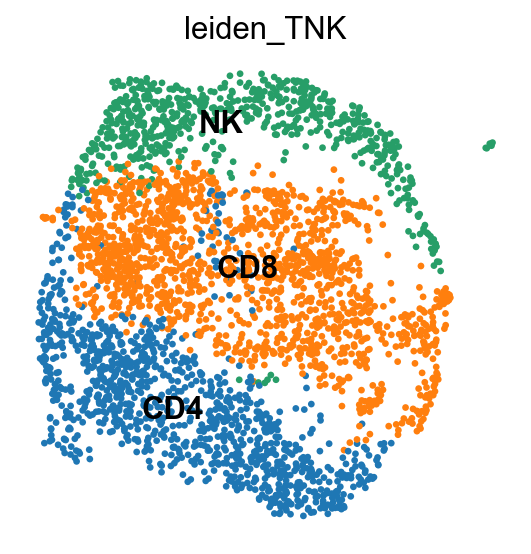

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


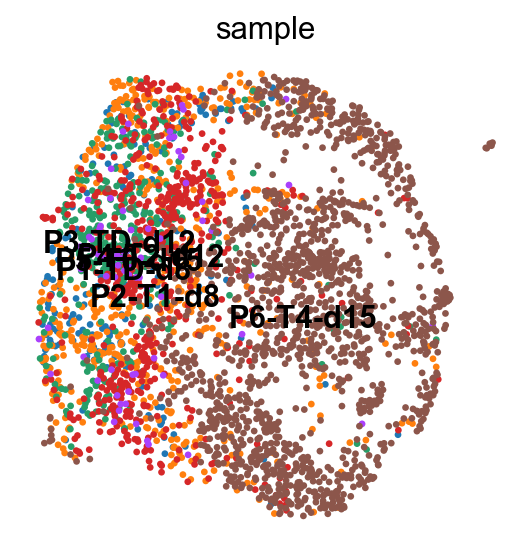

In [27]:
sc.pl.umap(adata2, color = 'leiden_TNK', legend_loc = 'on data')
sc.pl.umap(adata2, color = 'sample', legend_loc = 'on data')

In [35]:
trt_d8_d12_all = []
trt_d8_tnk = np.where(adata2.obs['sample'] == 'P2-T1-d8')[0]
trt_d12_tnk = np.where(adata2.obs['sample'] == 'P4-T2-d12')[0]
adata4 = adata2[np.concatenate((trt_d8_tnk, trt_d12_tnk)), :]
trt_d8_d12_all.append(adata4.copy())

In [36]:
concat_data3 = ad.concat(trt_d8_d12_all, join='outer')
concat_data3

AnnData object with n_obs × n_vars = 1108 × 19059
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'hashing', 'leiden', 'hashtag', 'CD45', 'leiden_0.6', 'leiden_new', 'nn_80', 'leiden_0.4', 'leiden_TNK'
    obsm: 'X_pca', 'X_umap'

In [37]:
concat_data3 = remove_recompute(concat_data3)

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


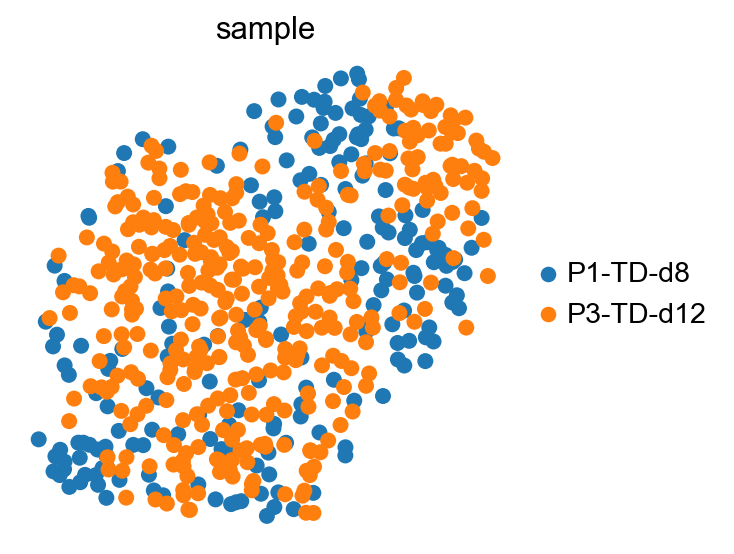

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [31]:
sc.pl.umap(concat_data3, color = 'sample')
sc.pl.umap(concat_data3, color = 'leiden_TNK', legend_loc = 'on data')

In [38]:
cd4 = concat_data3[concat_data3.obs['leiden_TNK'].str.contains('CD4')]
cd4

View of AnnData object with n_obs × n_vars = 426 × 19059
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'hashing', 'leiden', 'hashtag', 'CD45', 'leiden_0.6', 'leiden_new', 'nn_80', 'leiden_0.4', 'leiden_TNK'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib

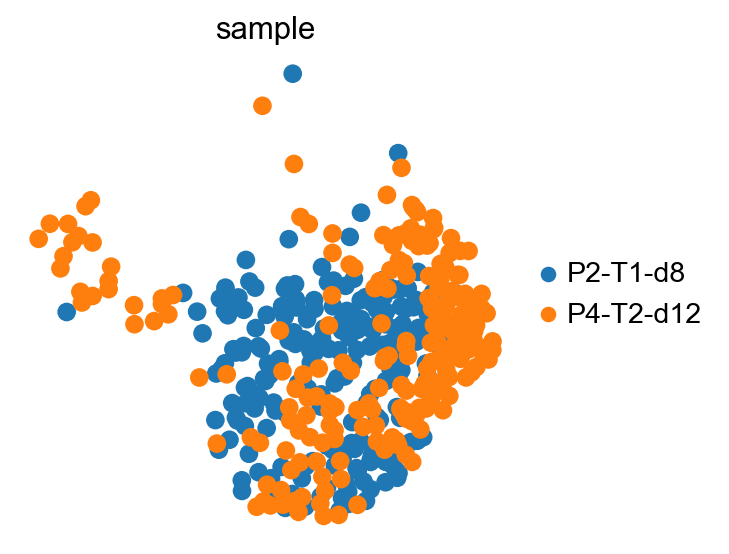

In [39]:
sc.pl.umap(cd4, color = 'sample')

In [40]:
cd4.obs['sample'].value_counts()

sample
P4-T2-d12    216
P2-T1-d8     210
Name: count, dtype: int64

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


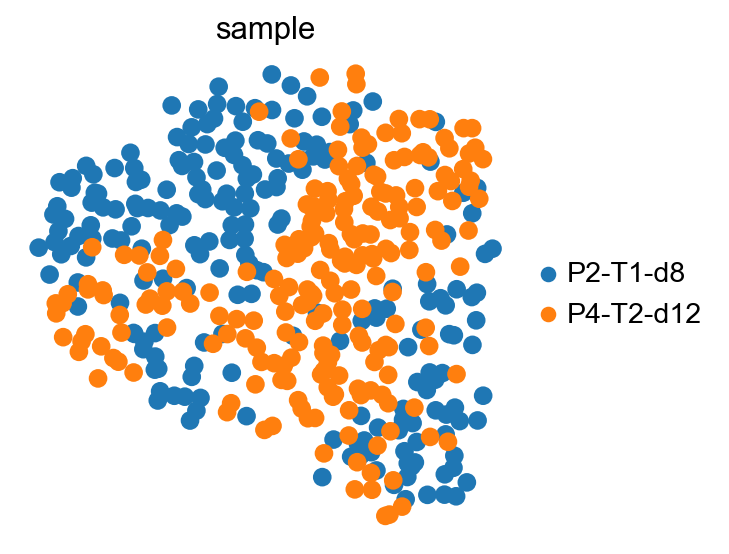

In [41]:
del cd4.uns, cd4.obsm, cd4.varm, cd4.obsp
sc.tl.pca(cd4, svd_solver='arpack')
sc.pp.neighbors(cd4, n_neighbors=10, n_pcs=40)  # using with default parameters
sc.tl.umap(cd4)
sc.pl.umap(cd4, color='sample')

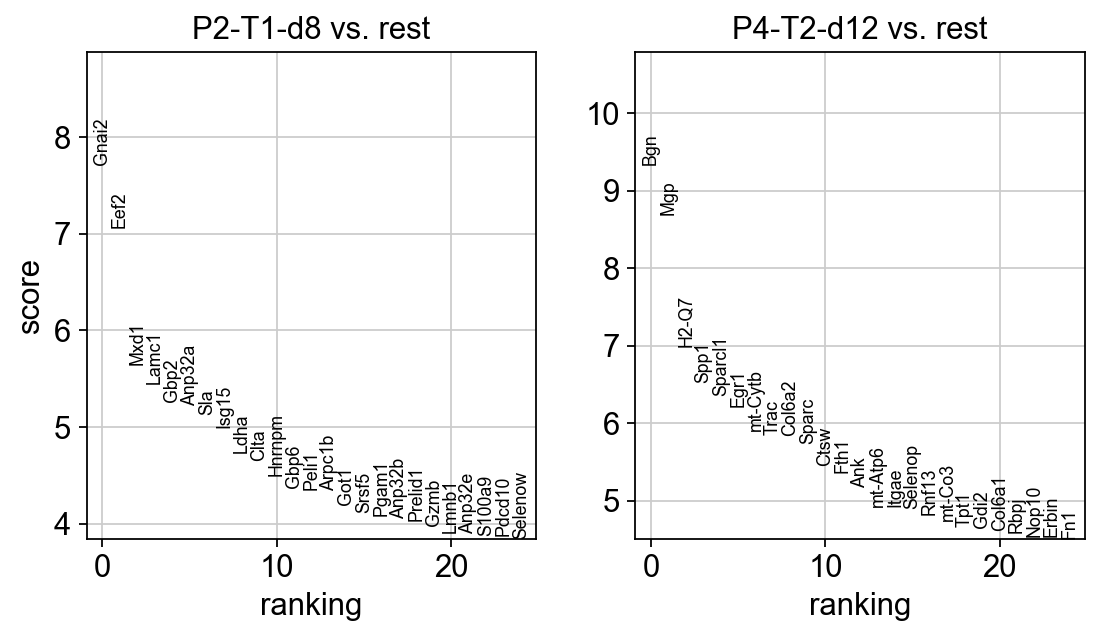

In [42]:
sc.tl.rank_genes_groups(cd4, groupby='sample', key_added='cd4_DE_results')
sc.pl.rank_genes_groups(cd4, n_genes=25, sharey=False, key='cd4_DE_results')

In [43]:
write_deres(file_dir + 'GAP_flex_treated_d8_vs_d12_cd4_DEGs.xlsx', cd4, 'sample', 'cd4_DE_results')

In [44]:
cd8 = concat_data3[concat_data3.obs['leiden_TNK'].str.contains('CD8')]
cd8

View of AnnData object with n_obs × n_vars = 435 × 19059
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'hashing', 'leiden', 'hashtag', 'CD45', 'leiden_0.6', 'leiden_new', 'nn_80', 'leiden_0.4', 'leiden_TNK'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib

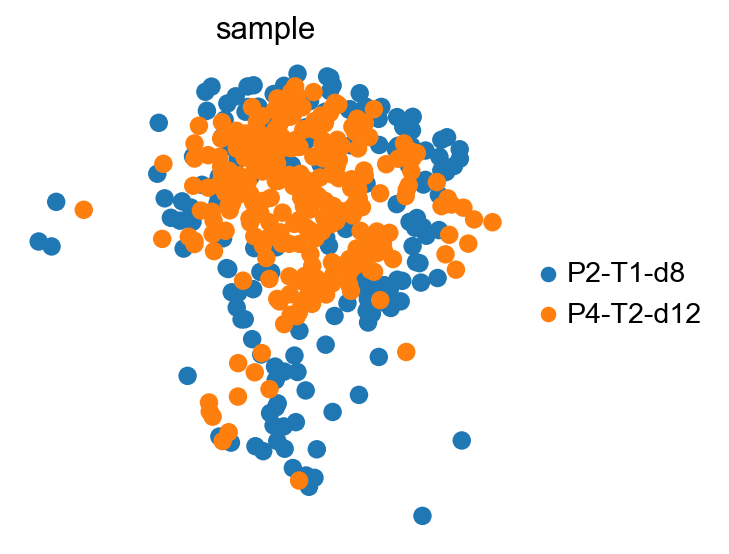

sample
P4-T2-d12    267
P2-T1-d8     168
Name: count, dtype: int64

In [45]:
sc.pl.umap(cd8, color = 'sample')
cd8.obs['sample'].value_counts()

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


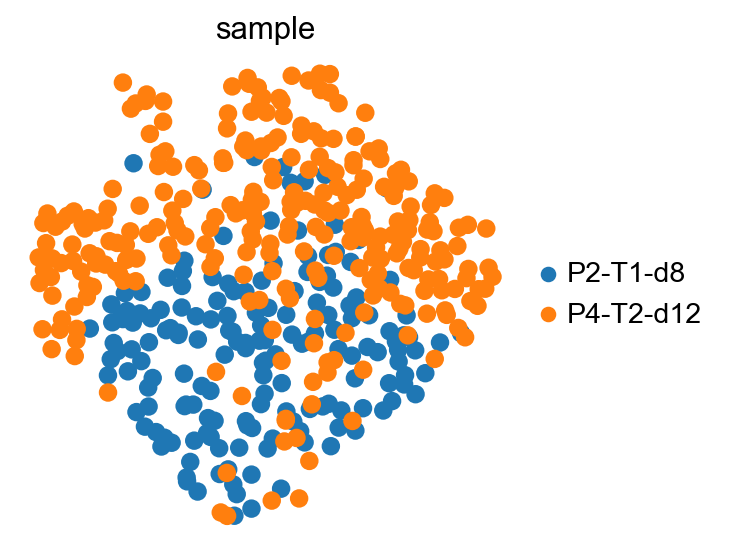

In [46]:
del cd8.uns, cd8.obsm, cd8.varm, cd8.obsp
sc.tl.pca(cd8, svd_solver='arpack')
sc.pp.neighbors(cd8, n_neighbors=10, n_pcs=40)  # using with default parameters
sc.tl.umap(cd8)
sc.pl.umap(cd8, color='sample')

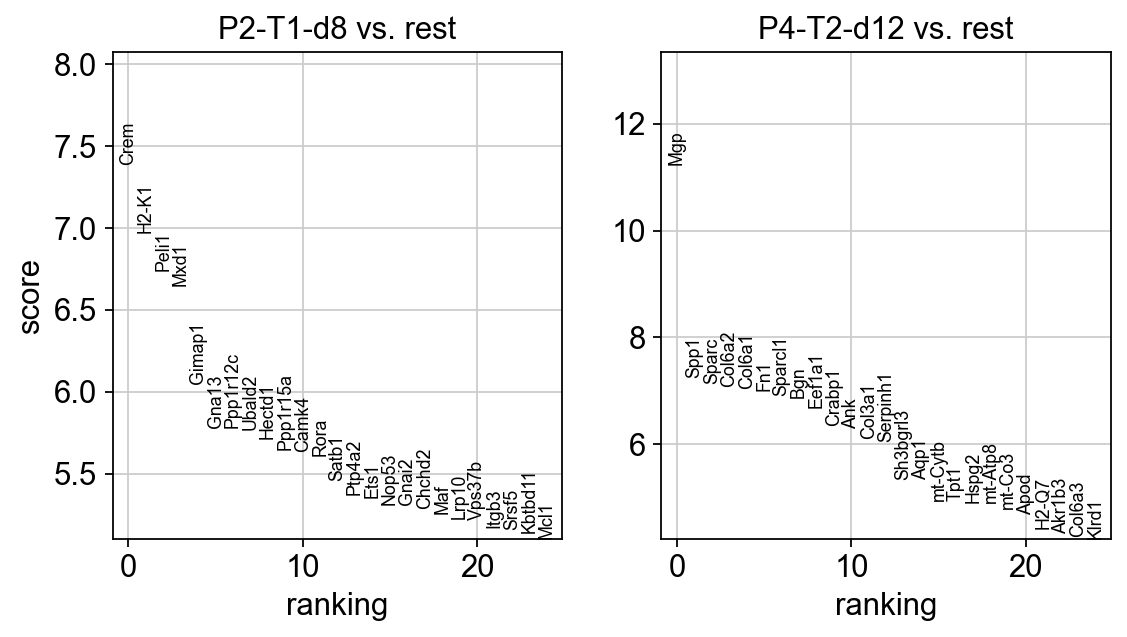

In [47]:
sc.tl.rank_genes_groups(cd8, groupby='sample', key_added='cd8_DE_results')
sc.pl.rank_genes_groups(cd8, n_genes=25, sharey=False, key='cd8_DE_results')

In [48]:
write_deres(file_dir + 'GAP_flex_treated_d8_vs_d12_cd8_DEGs.xlsx', cd8, 'sample', 'cd8_DE_results')

In [49]:
nk = concat_data3[concat_data3.obs['leiden_TNK'].str.contains('NK')]
nk

View of AnnData object with n_obs × n_vars = 247 × 19059
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'hashing', 'leiden', 'hashtag', 'CD45', 'leiden_0.6', 'leiden_new', 'nn_80', 'leiden_0.4', 'leiden_TNK'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib

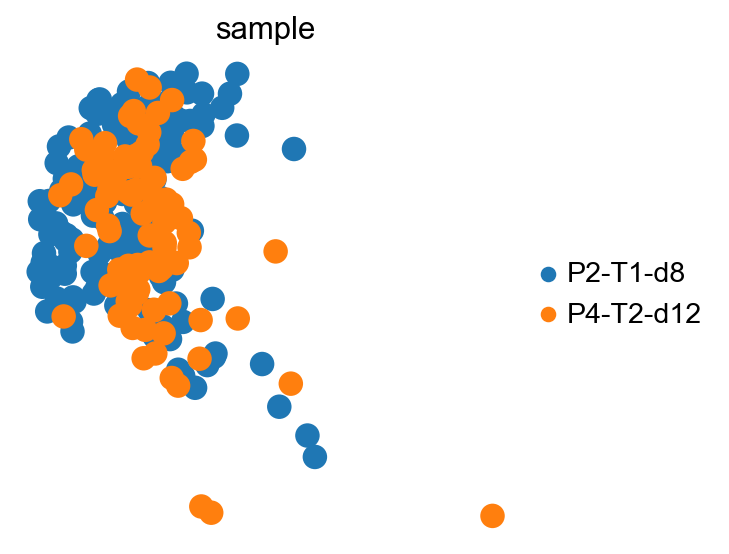

sample
P2-T1-d8     153
P4-T2-d12     94
Name: count, dtype: int64

In [50]:
sc.pl.umap(nk, color = 'sample')
nk.obs['sample'].value_counts()


/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


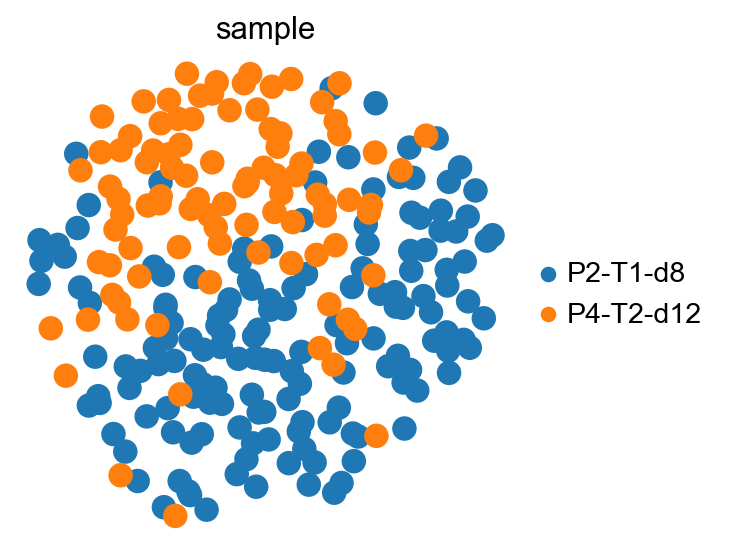

In [51]:
del nk.uns, nk.obsm, nk.varm, nk.obsp
sc.tl.pca(nk, svd_solver='arpack')
sc.pp.neighbors(nk, n_neighbors=10, n_pcs=40)  # using with default parameters
sc.tl.umap(nk)
sc.pl.umap(nk, color='sample')

In [52]:
sc.tl.rank_genes_groups(nk, groupby='sample', key_added='nk_DE_results')
sc.pl.rank_genes_groups(nk, n_genes=25, sharey=False, key='nk_DE_results')

In [53]:
write_deres(file_dir + 'GAP_flex_treated_d8_vs_d12_nk_DEGs.xlsx', nk, 'sample', 'nk_DE_results')